## Levy Stable models of Stochastic Volatility

This tutorial demonstrates inference using the Levy [Stable](http://docs.pyro.ai/en/stable/distributions.html#stable) distribution through a motivating example of a non-Gaussian stochastic volatilty model.

Inference with stable distribution is tricky because the density `Stable.log_prob()` is not defined. In this tutorial we demonstrate two approaches to inference: (i) usinng the [poutine.reparam](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) effect to transform models in to a tractible form, and (ii) using the likelihood-free loss [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance) with SVI.


#### Summary 

- [Stable.log_prob()](http://docs.pyro.ai/en/stable/distributions.html#stable) is undefined.
- Stable inference requires either reparameterization or a likelihood-free loss.
- Reparameterization:
    - The [poutine.reparam()](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) handler can transform models using various [strategies](http://docs.pyro.ai/en/latest/infer.reparam.html).
    - The [SymmetricStableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.SymmetricStableReparam) strategy can be used for Stable distributions in SVI or HMC.
    - The [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam) strategy allows skew, but cannot be used for likelihoods.
    - The [DiscreteCosineReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.discrete_cosine.DiscreteCosine) strategy improves geometry in batched latent time series models.
- Likelihood-free loss with SVI:
    - The [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance) loss allows stable distributions in the guide and in model likelihoods.

#### Table of contents

- [Daily S&P data](#data)
- [Fitting a single distribution to log returns](#fitting) using `EnergyDistance`
- [Modeling stochastic volatility](#modeling) using `poutine.reparam`

## Daily S&P 500 data <a class="anchor" id="data"></a>

The following daily closing prices for the S&P 500 were loaded from [Yahoo finance](https://finance.yahoo.com/quote/%5EGSPC/history/).

In [1]:
import math
import os
import torch
import pyro
import pyro.distributions as dist
from matplotlib import pyplot
from torch.distributions import constraints

from pyro import poutine
from pyro.contrib.examples.finance import load_snp500
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, SymmetricStableReparam
from pyro.optim import ClippedAdam
from pyro.ops.tensor_utils import convolve

%matplotlib inline
assert pyro.__version__.startswith('1.1.0')
pyro.enable_validation(True)
smoke_test = ('CI' in os.environ)

In [2]:
df = load_snp500()
dates = df.Date.to_numpy()
x = torch.tensor(df["Close"]).float()
x.shape

torch.Size([23116])

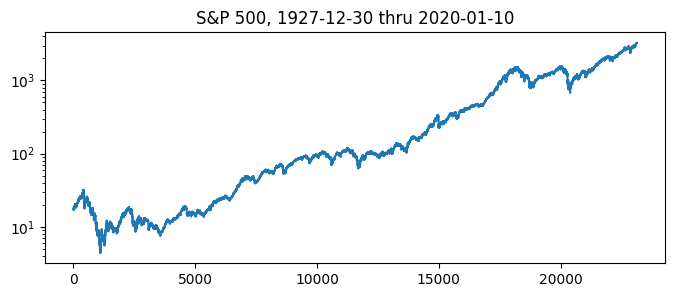

In [3]:
pyplot.figure(figsize=(8, 3))
pyplot.plot(x)
pyplot.yscale('log')
pyplot.title("S&P 500, {} thru {}".format(dates[0], dates[-1]));


Of interest are the log returns, i.e. the log ratio of price on two subsequent days.

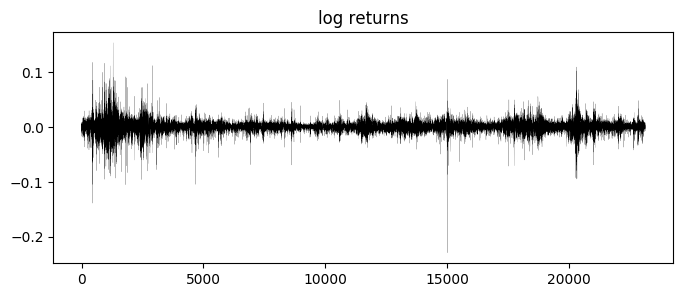

In [4]:
pyplot.figure(figsize=(8, 3))
r = (x[1:] / x[:-1]).log()
pyplot.plot(r, "k", lw=0.1)
pyplot.title("log returns");

mean = 0.0002258
std = 0.01186


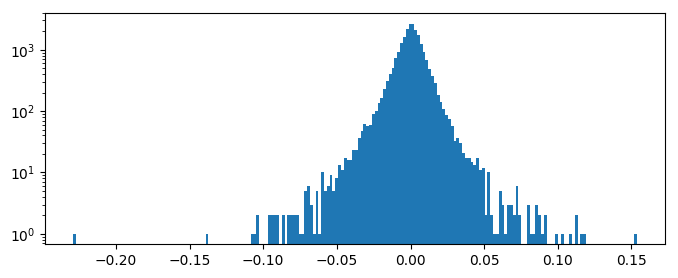

In [5]:
pyplot.figure(figsize=(8, 3))
pyplot.hist(r, bins=200)
pyplot.yscale('log')
print("mean = {:0.4g}".format(r.mean()))
print("std = {:0.4g}".format(r.std()))

## Fitting a single distribution to log returns  <a class="anchor" id="fitting"></a>

Log returns appear to be heavy-tailed. First let's fit a single distribution to the returns. To fit the distribution, we'll use a likelihood free statistical inference algorithm [EnergyDistance](http://docs.pyro.ai/en/latest/inference_algos.html#pyro.infer.energy_distance.EnergyDistance), which matches fractional moments of observed data and can handle data with heavy tails.

In [6]:
def model():
    stability = pyro.param("stability", torch.tensor(1.9),
                           constraint=constraints.interval(0, 2))
    skew = 0.
    scale = pyro.param("scale", torch.tensor(0.1), constraint=constraints.positive)
    loc = pyro.param("loc", torch.tensor(0.))
    with pyro.plate("data", len(r)):
        return pyro.sample("r", dist.Stable(stability, skew, scale, loc), obs=r)

step 0 loss = 8.961664199829102
step 20 loss = 4.8506011962890625
step 40 loss = 1.5543489456176758
step 60 loss = 1.7787070274353027
step 80 loss = 1.4140945672988892
step 100 loss = 1.3671720027923584
step 120 loss = 1.287503719329834
step 140 loss = 1.2791334390640259
step 160 loss = 1.2810490131378174
step 180 loss = 1.2784368991851807
step 200 loss = 1.2823134660720825
loc = 0.0003696
scale = 0.00872
stability = 1.977
CPU times: user 15.7 s, sys: 629 ms, total: 16.3 s
Wall time: 2.45 s


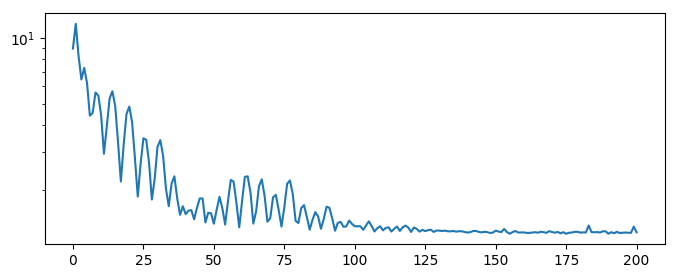

In [7]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 201
optim = ClippedAdam({"lr": 0.1, "lrd": 0.1 ** (1 / num_steps)})
svi = SVI(model, lambda: None, optim, EnergyDistance())
losses = []
for step in range(num_steps):
    loss = svi.step()
    losses.append(loss)
    if step % 20 == 0:
        print("step {} loss = {}".format(step, loss))

pyplot.figure(figsize=(8, 3))
pyplot.plot(losses)
pyplot.yscale('log')
for name, value in sorted(pyro.get_param_store().items()):
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.squeeze().item()))

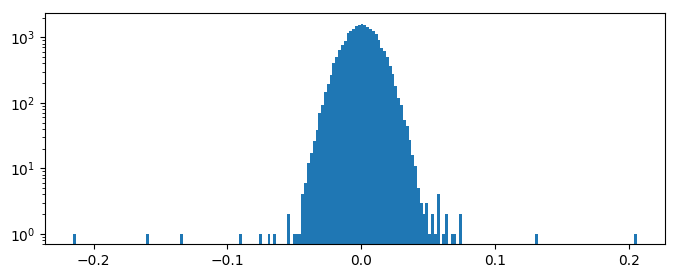

In [8]:
samples = poutine.uncondition(model)().detach()
pyplot.figure(figsize=(8, 3))
pyplot.hist(samples, bins=200)
pyplot.yscale('log')

This is a poor fit, but that was to be expected since we are mixing all time steps together: we would expect this to be a scale-mixture of distributions (Normal, or Stable), but are modeling it as a single distribution (Stable in this case).

## Modeling stochastic volatility  <a class="anchor" id="modeling"></a>

Consider a stochastic volatity model of the log returns `r_t` and a latent volatility `h`:
$$
  \log h_t = \delta + \phi \log h_{t-1} + \sigma v_t \\
  r_t = w_t \sqrt{h_t}
$$
Usually $\sigma v_1$ and $w_t$ are both Gaussian. We will generalize to a symmetric Stable distributoin for $w_t$.

In [9]:
def model(data):
    # We model volatility as a Gaussian process, where h_noise are the independent increments.
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_scale = pyro.sample("h_scale", dist.LogNormal(0, 1)).unsqueeze(-1)
    h_loc = pyro.sample("h_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    h_noise = pyro.sample("h_noise", dist.Normal(0, 1).expand([len(data)]).to_event(1))
    log_h = pyro.deterministic("log_h", h_loc + h_scale * h_noise.cumsum(dim=-1))

    # Observed log returns, assumed to be a symmetric Stable distribution.
    r_scale = log_h.mul(0.5).exp().clamp(min=1e-8)
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    r_stability = pyro.sample("r_stability", dist.Uniform(1.01, 1.99)).unsqueeze(-1)
    pyro.sample("r", dist.Stable(r_stability, 0., r_scale, r_loc).to_event(1), obs=data)

We use two reparameterizers: [SymmetricStableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.SymmetricStableReparam) to handle the `Stable` likelihood (since `Stable.log_prob()` is undefined), and [DiscreteCosineReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.discrete_cosine.DiscreteCosineReparam) to improve geometry of the latent Gaussian process for `log_h`. We'll then use `reparam_model` for both inference and prediction.

In [10]:
reparam_model = poutine.reparam(model, {"h_noise": DiscreteCosineReparam(),
                                        "r": SymmetricStableReparam()})

step 0 loss = 15.3476
step 50 loss = 1.1854
step 100 loss = -0.911553
step 150 loss = -2.19603
step 200 loss = -2.46386
step 250 loss = -2.9688
step 300 loss = -3.05516
step 350 loss = -2.99866
step 400 loss = -3.09343
step 450 loss = -3.09285
step 500 loss = -3.11858
step 550 loss = -3.03673
step 600 loss = -3.10045
step 650 loss = -3.17701
step 700 loss = -3.17717
step 750 loss = -3.17318
step 800 loss = -3.14168
step 850 loss = -3.18831
step 900 loss = -3.18946
step 950 loss = -3.18951
step 1000 loss = -3.1747
h_loc = 0.00010664918227121234
h_scale = 0.13896547257900238
r_loc = 0.0003727242583408952
r_stability = 1.9649641513824463


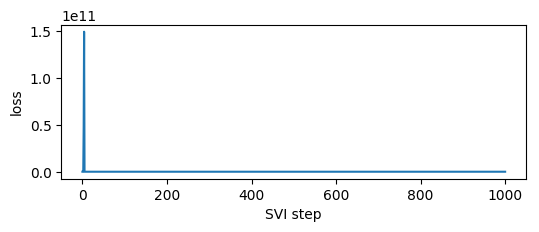

In [11]:
pyro.clear_param_store()
pyro.set_rng_seed(1234567890)
num_steps = 1 if smoke_test else 1001
optim = ClippedAdam({"lr": 0.1,
                     "betas": (0.9, 0.99),
                     "lrd": 0.01 ** (1 / num_steps)})
guide = AutoDiagonalNormal(reparam_model)
svi = SVI(reparam_model, guide, optim, Trace_ELBO())
losses = []
for step in range(num_steps):
    loss = svi.step(r) / len(r)
    losses.append(loss)
    if step % 50 == 0:
        median = guide.median()
        print("step {} loss = {:0.6g}".format(step, loss))

pyplot.figure(figsize=(6,2))
pyplot.plot(losses)
pyplot.ylabel("loss")
pyplot.xlabel("SVI step")
for name, value in sorted(guide.median().items()):
    if value.numel() == 1:
        print("{} = {}".format(name, value.squeeze().item()))

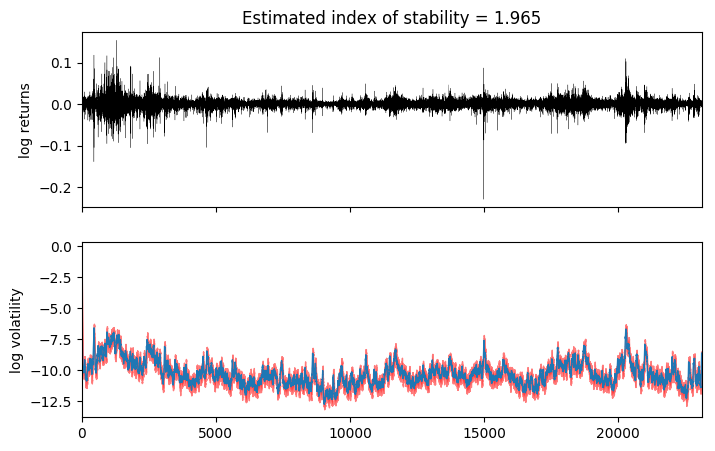

In [12]:
fig, axes = pyplot.subplots(2, figsize=(8, 5), sharex=True)
axes[0].plot(r, "k", lw=0.2)
axes[0].set_ylabel("log returns")
axes[0].set_xlim(0, len(r))

# We will pull out median log returns using the autoguide's .median() and poutines.
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=20, parallel=True)(r)
log_h = pred["log_h"]
axes[1].plot(log_h.median(0).values, lw=1)
axes[1].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(2, dim=0).values,
                     log_h.kthvalue(18, dim=0).values,
                     color='red', alpha=0.5)
axes[1].set_ylabel("log volatility")

stability = pred["r_stability"].median(0).values.item()
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability));